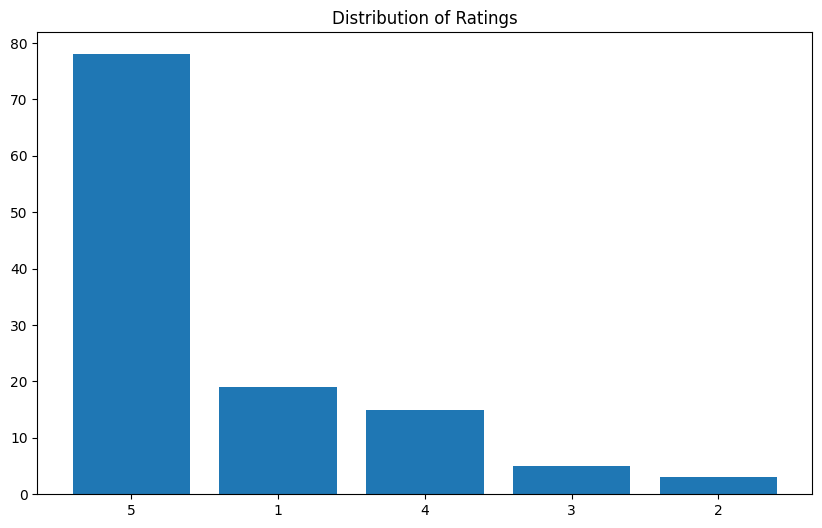

In [ ]:
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
from random import randint
from time import sleep
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Adding headers to avoid getting blocked by website
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'}
reviews = []

#Function to extract text from the HTML element
def extract_text(item, selector):
    try:
      return item.find(selector).text
    except AttributeError:
      return None

#Function to get reviews from a given page
def getReviews(page):

    #URL for the page
    url = f'https://uk.trustpilot.com/review/azimo.com?page={page}'
    r = rq.get(url, headers=headers)
    soup = bs(r.text, 'html.parser')

    #Extracting reviews
    company_review = soup.findAll('div', attrs = {'class':'styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ'}) 

    for item in company_review:

        tag_reviews = 'p', {'class': 'typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn'}
        tag_title = 'h2',{'class': 'typography_heading-s__f7029 typography_appearance-default__AAY17' }

        columns = {
        'title':extract_text(item,tag_title) ,
        'reviews':extract_text(item,tag_reviews),
        'location': item.find('div', {'class': 'typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua'}).text,
        'ratings': str(item.find_all('img', alt = True)),
        'datetime': item.time.attrs['datetime'],
        
        }
        #Appending the extracted data to the reviews list
        reviews.append(columns)    
    return

#Loop to get reviews from multiple pages    
for x in range(1,7):
    print('Downloading page number', x)
    getReviews(x)

    #Adding random sleep time between requests to avoid getting blocked
    sleep(randint(3, 5))

#Creating a DataFrame from the reviews list
df = pd.DataFrame(reviews)

df
#Writing the DataFrame to an excel file
df.to_excel('raw_reviews.xlsx', index=False)
train = df.copy()

try:
    train['ratings'] = train['ratings'].str.extract('Rated (.+?) out of', expand=False).str.strip()
except AttributeError:
    train['ratings'] = "none"


def time_convert(date_to_convert):
     return datetime.datetime.strptime(date_to_convert, '%Y-%m-%dT%H:%M:%S.%f%z').strftime('%H:%M:%S')

def date(date_to_convert):
     return datetime.datetime.strptime(date_to_convert, '%Y-%m-%dT%H:%M:%S.%f%z').strftime('%d/%m/%Y')

train['time'] = train['datetime'].apply(time_convert)
train['date'] = train['datetime'].apply(date)
train.drop(['datetime'], axis=1, inplace=True)
train

train.to_excel('cleaned_reviews.xlsx', index=False)



# Get count of ratings
rating_counts = train['ratings'].value_counts()

# Set figure size and title
plt.figure(figsize=(10, 6))
plt.title('Distribution of Ratings')

# Plot bar chart
plt.bar(rating_counts.index, rating_counts.values)

# Set x-axis tick labels
plt.xticks(rating_counts.index)

# Show plot
plt.show()



